Required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import time
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import pickle
from scipy.integrate import quad

### Task 1

Preliminarly, verify the form of the density function $ρ(r)$ by inferring it from the particle distribution
and compare it with the analytical density function described in the original paper
by Hernquist (from 1990 on Astrophysical Journal available on the web). Use Poissonian error
bars1 when comparing the numerical density profile with the analytical expected values.

Note that the initial conditions are given in a system of units in which G=1. Assume reasonable
units of length and mass for your calculations (units of velocity and time follow automatically
from the assumption G=1) and discuss your choice.

### Defining the units

As mentioned the data is initialized with G = 1, then one has to set some unit scales to describe the system physically. Since the questioned distribution of star resembles a globular cluster (GC) then in this case for distance we will use 1 parsec $[pc]$ and 1 solar mass $[M_{\odot}]$. Specifying these scales with CGS units one gets: 


$[pc] = 3.086 \cdot 10^{18} [cm]$ 

$[M_{\odot}] = 1.989 \cdot 10^{33} [g]$ 

From these the time scale and velocity should follow from:

$[S] = \sqrt{\frac{[R]^3}{G \cdot [M]}}$

$[time] = \sqrt{\frac{[length]^3}{G \cdot [mass]}}$

So if we assign for data the length and mass scales 1 $pc$ and 1 $M_{\odot}$ then the time and velocity will be in CGS system:

$[S] = 1.216 \cdot 10^{11} [s]$

First let's read in the data (success)

I will add a "distance" column to the data which describes each stars' distance from the center

"v_mag" will also be added that describes the magnitude of velocities 

In [2]:
# Specify the file path
file_path = './data.txt'

# Define column names
column_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'soft', 'pot']

# Read the .txt file into a DataFrame
df_stars = pd.read_csv(file_path, sep='\t', header=None, names=column_names)

# Add distance
df_stars['distance'] = np.sqrt(df_stars['x']**2 + df_stars['y']**2 + df_stars['z']**2)
# Add velocity magnitude
df_stars['v_mag'] = np.sqrt(df_stars['vx']**2 + df_stars['vy']**2 + df_stars['vz']**2)


# Display the DataFrame
df_stars.describe()

mass             x             y             z            vx  \
count  5.001000e+04  50010.000000  50010.000000  50010.000000  50010.000000   
mean   9.242590e+01     -0.016719     -0.019048      0.020731     -2.439695   
std    6.330999e-11      4.177673      5.778122      4.815739   1788.472427   
min    9.242590e+01   -278.837000   -635.776000   -269.974000  -7231.980000   
25%    9.242590e+01     -0.078246     -0.078350     -0.078522  -1043.697500   
50%    9.242590e+01     -0.000038     -0.000246      0.000005     -3.254445   
75%    9.242590e+01      0.078801      0.076801      0.079093   1037.512500   
max    9.242590e+01    199.444000    604.998000    354.422000   7525.940000   

                 vy            vz          soft           pot      distance  \
count  50010.000000  50010.000000  5.001000e+04  5.001000e+04  50010.000000   
mean      10.367863      4.887935  1.000000e-01  1.302150e-02      1.083783   
std     1797.099842   1764.619866  1.323954e-14  5.880771e-16      8.535658   
min    -7930.760000  -7952.250000  1.000000e-01  1.302150e-02      0.000366   
25%    -1036.050000  -1004.350000  1.000000e-01  1.302150e-02      0.079031   
50%        9.534195      9.986930  1.000000e-01  1.302150e-02      0.188728   
75%     1051.287500   1023.600000  1.000000e-01  1.302150e-02      0.505495   
max     7874.570000   7595.740000  1.000000e-01  1.302150e-02    724.689658   

              v_mag  
count  50010.000000  
mean    2694.907822  
std     1509.817432  
min       23.568200  
25%     1524.306726  
50%     2483.325062  
75%     3647.233147  
max     8518.785337

In [3]:
df_stars

mass         x         y         z         vx        vy          vz  \
0      92.4259 -0.003816 -0.079670 -0.019072  3779.6200   354.734   -73.45010   
1      92.4259 -0.032298 -0.249461 -0.010890  3250.5900  -674.280   -18.33470   
2      92.4259  0.067577 -0.810356 -0.006849  2190.8600   199.053     3.86061   
3      92.4259 -0.152755  0.276704 -0.002704 -2695.1400 -1345.020   105.94600   
4      92.4259 -0.216623  0.150557 -0.002755 -1811.8900 -2595.570    85.85910   
...        ...       ...       ...       ...        ...       ...         ...   
50005  92.4259 -0.034591 -0.004853  0.038082  2274.8300  4239.630  -225.45900   
50006  92.4259  0.100105 -0.006709 -0.025669  -751.0680 -1963.650   113.92200   
50007  92.4259  0.045565 -0.075928  0.023182  -782.9830   581.401   608.46500   
50008  92.4259  0.273587  0.567563  0.255294   -20.4115  -212.075  -715.19100   
50009  92.4259 -0.122016 -0.116939 -0.217751   360.5420   113.263  3277.85000   

       soft       pot  distance        v_mag  
0       0.1  0.013022  0.082010  3796.940673  
1       0.1  0.013022  0.251779  3319.838103  
2       0.1  0.013022  0.813198  2199.887393  
3       0.1  0.013022  0.316080  3013.981250  
4       0.1  0.013022  0.263819  3166.591351  
...     ...       ...       ...          ...  
50005   0.1  0.013022  0.051675  4816.652969  
50006   0.1  0.013022  0.103561  2105.469707  
50007   0.1  0.013022  0.091535  1149.486475  
50008   0.1  0.013022  0.679818   746.251031  
50009   0.1  0.013022  0.275641  3299.563557  

[50010 rows x 11 columns]

First plotting the stars in a 3d coordinate system

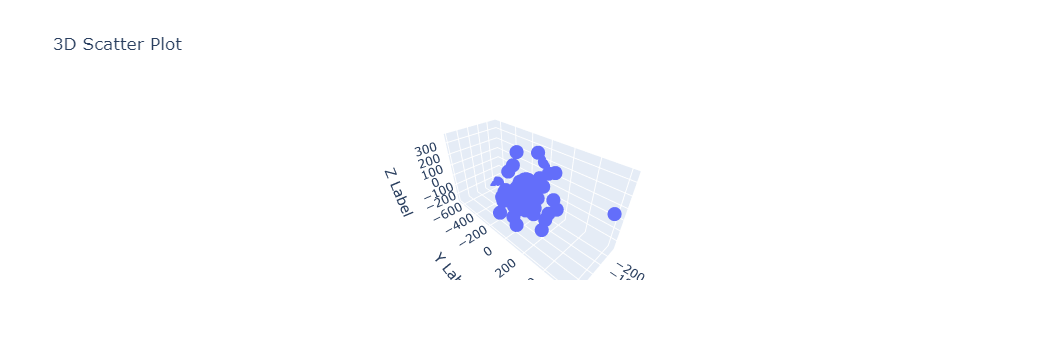

In [4]:
# Assuming df is your DataFrame
# Replace 'x', 'y', 'z' with your actual column names
fig = px.scatter_3d(df_stars, x='x', y='y', z='z', title='3D Scatter Plot', size_max = 1)

# You can customize the labels for each axis
fig.update_layout(scene=dict(xaxis_title='X Label', yaxis_title='Y Label', zaxis_title='Z Label'))

# Show the interactive plot
fig.show()

### Fitting the hernquist profile

First let's define Hernquist profile for the system. We can get the total mass for the system, since the data for that is given. The r is a variable in my control also. What is unknown is the scale factor a which I will get once I fit the profile to empirical data. Fot that I will use scipy's curve_fit.

I will describe the poissonian error as follows:

$e_{pos} = \frac{\left|\rho_{exact}-\rho_{numerical} \right|}{\sqrt{N_{\rho}}}$

where $\rho_{exact}$ and $\rho_{numerical}$ are the star densities form the solved hernquist profile and numerical profile respectively. $N_{\rho}$ indicates the number of stars per bin

To get the first quess fot the hernquist profile scale radius I will use the half mass formula from the hernquist profile:

$r_{\frac{1}{2}} = (1 + \sqrt{2}) \cdot a$

Since all the stars in this system have same masses, the half mass radius is straight forward. I will find the radius where the radius is when around 25005 stars are left.

In [5]:
r_half = 0.18874
f_df_stars = df_stars[df_stars['distance'] <= r_half]
f_df_stars.describe()

mass             x             y             z            vx  \
count  2.500500e+04  25005.000000  25005.000000  25005.000000  25005.000000   
mean   9.242590e+01     -0.000367      0.000006     -0.000435      2.822476   
std    2.087616e-11      0.057361      0.056588      0.056842   2192.670435   
min    9.242590e+01     -0.185048     -0.184957     -0.185508  -7231.980000   
25%    9.242590e+01     -0.031586     -0.030978     -0.031469  -1478.490000   
50%    9.242590e+01     -0.000219      0.000088     -0.000340      1.957230   
75%    9.242590e+01      0.030804      0.031566      0.030747   1486.950000   
max    9.242590e+01      0.187356      0.185406      0.184472   7525.940000   

                 vy            vz          soft           pot      distance  
count  25005.000000  25005.000000  2.500500e+04  2.500500e+04  25005.000000  
mean       8.298934      3.762507  1.000000e-01  1.302150e-02      0.085063  
std     2212.636519   2178.371775  4.714379e-14  2.494582e-15      0.049877  
min    -7930.760000  -7952.250000  1.000000e-01  1.302150e-02      0.000366  
25%    -1496.320000  -1457.980000  1.000000e-01  1.302150e-02      0.042932  
50%        9.200410      7.494210  1.000000e-01  1.302150e-02      0.079029  
75%     1505.600000   1472.740000  1.000000e-01  1.302150e-02      0.123677  
max     7874.570000   7595.740000  1.000000e-01  1.302150e-02      0.188707

So this brute force half mass radius seems to be around 0.18874 $pc$ from this the a will be

In [111]:
a_guess = r_half / ( 1 + np.sqrt(2))
print(f'a_guess is {a_guess}')

a_guess is [0.07817867]


In [7]:
total_mass = df_stars.shape[0]*df_stars["mass"].values[0]#N stars times mass, since they all the sam I fix it in the profile
print(f'Total mass of the system is {total_mass} M_sol')

Total mass of the system is 4622219.259 M_sol


The hernquist profile is defined as follows


$\rho(r) = \frac{M_{tot}}{2 \cdot \pi} \frac{a}{r} \frac{1}{(r+a)^3} \quad[\frac{M_{\odot}}{{pc}^3}]$

Since the total mass is fixed the only unknown will be the scale radius a

In [61]:
#Defininf total mass and hernquist profiles
total_mass = df_stars.shape[0]*df_stars["mass"].values[0]#N stars times mass, since they all the sam I fix it in the profile

def hernquist_profile(r, M, a):
    return M / (2 * np.pi) * (a / r) * (1/(r + a)**3)

def hernquist_profile_fixed_M(r, a):
    return total_mass / (2 * np.pi) * (a / r) * (1/(r + a)**3)

In [35]:
total_mass

4622219.259

PLot the observed data density and its radial dependence

/scratch/tmp.43386498.atepper/ipykernel_11754/3333241215.py:23: RuntimeWarning:

divide by zero encountered in divide



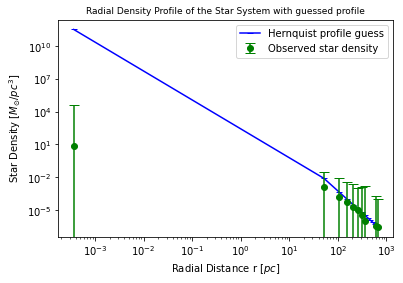

In [112]:
# define radial distances
radial_distances = df_stars["distance"]

# Define radial bins with equal length
bins = np.linspace(np.min(radial_distances), np.max(radial_distances), 15)

#bins = np.logspace(np.log(np.min(radial_distances)), np.log(np.max(radial_distances)), 50)
# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=bins)

#find the denisty of stars in solar_masses per cubic parsec
# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
lone_star_mass = df_stars["mass"].values[0]
star_density = hist*lone_star_mass / shell_volumes 

#Guessef fixed mass profile
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_guess)

#Error
e_pos = abs(fixed_M_fitted_profile-star_density)/np.sqrt(hist)#Encounter zero


# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], fixed_M_fitted_profile, marker='_',label='Hernquist profile guess', color='blue')
#plt.scatter(bin_edges[1:], star_density, marker='o',label='Observed star density', color='green')
plt.errorbar(bin_edges[:-1],star_density, yerr=np.sqrt(e_pos), fmt='o', capsize=5,label='Observed star density', color='green')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Radial Distance r $[pc]$')
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]')
plt.title('Radial Density Profile of the Star System with guessed profile', fontsize = 9)
plt.show()

Using the a guess falls in to the error bars for the outer stars, but the profile has problems near center. Maybe because of binning.

Now try to fit the profile

In [171]:
total_mass

4622219.259

In [75]:
total_mass = df_stars.shape[0]*df_stars["mass"].values[0]#N stars times mass, since they all the sam I fix it in the profile
def hernquist_profile_fixed_M(r, a):
    return 4622219.259/ (2 * np.pi) * (a / r) * (1/(r + a)**3)

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:756: RuntimeWarning:

divide by zero encountered in divide

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated

/scratch/tmp.43386498.atepper/ipykernel_11754/428110446.py:24: RuntimeWarning:

divide by zero encountered in divide



fixed mass profile a value:[0.07817867]


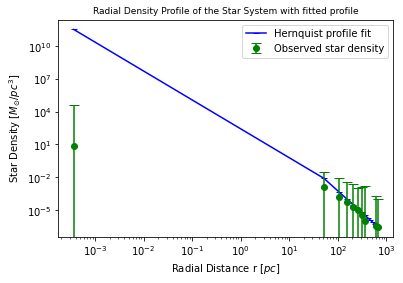

In [38]:
# define radial distances
radial_distances = df_stars["distance"]

# Define radial bins with equal length
bins = np.linspace(np.min(radial_distances), np.max(radial_distances), 15)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
lone_star_mass = df_stars["mass"].values[0]
star_density = hist*lone_star_mass / shell_volumes 


a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density, p0=a_guess, sigma = np.sqrt(star_density),absolute_sigma = True)
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)
print(f'fixed mass profile a value:{a_fit}')


#Error
e_pos = abs(fixed_M_fitted_profile-star_density)/np.sqrt(hist)#Encounter zero




# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], fixed_M_fitted_profile, marker='_',label='Hernquist profile fit', color='blue')
#plt.scatter(bin_edges[1:], star_density, marker='o',label='Observed star density', color='green')
plt.errorbar(bin_edges[:-1],star_density, yerr=np.sqrt(e_pos), fmt='o', capsize=5,label='Observed star density', color='green')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Radial Distance r $[pc]$')
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]')
plt.title('Radial Density Profile of the Star System with fitted profile', fontsize = 9)
plt.show()

Comparing a fit and a guess:

In [11]:
a_guess

0.07817866776229795

In [12]:
a_fit

array([0.07817867])

In [13]:
pcov

array([[inf]])

Still have to do something about the binning the pcov is inf

In [15]:
a_fit

array([0.07817867])

a_fit

Compute the direct N-Body forces between particles (note that the array potential[i] is not
needed for this purpose). Start by assuming a softening of the order of the mean interparticle
separation in the system, then repeat the force calculation by experimenting with different
values of the softening and discuss your results.

The mean interparticle separation in the system should be calculated inside the half-mass radius 

$r_{\frac{1}{2}} = (1 + \sqrt{2}) \cdot a$

In [42]:
r_half = (1 + np.sqrt(2))*a_fit
print(f'fitted half mass radius: {r_half} [pc]')

fitted half mass radius: [0.18874] [pc]


In [43]:
f_df_stars = df_stars[df_stars['distance'] <= r_half[0]]
f_df_stars.describe()

mass             x             y             z            vx  \
count  2.500500e+04  25005.000000  25005.000000  25005.000000  25005.000000   
mean   9.242590e+01     -0.000367      0.000006     -0.000435      2.822476   
std    2.087616e-11      0.057361      0.056588      0.056842   2192.670435   
min    9.242590e+01     -0.185048     -0.184957     -0.185508  -7231.980000   
25%    9.242590e+01     -0.031586     -0.030978     -0.031469  -1478.490000   
50%    9.242590e+01     -0.000219      0.000088     -0.000340      1.957230   
75%    9.242590e+01      0.030804      0.031566      0.030747   1486.950000   
max    9.242590e+01      0.187356      0.185406      0.184472   7525.940000   

                 vy            vz          soft           pot      distance  
count  25005.000000  25005.000000  2.500500e+04  2.500500e+04  25005.000000  
mean       8.298934      3.762507  1.000000e-01  1.302150e-02      0.085063  
std     2212.636519   2178.371775  4.714379e-14  2.494582e-15      0.049877  
min    -7930.760000  -7952.250000  1.000000e-01  1.302150e-02      0.000366  
25%    -1496.320000  -1457.980000  1.000000e-01  1.302150e-02      0.042932  
50%        9.200410      7.494210  1.000000e-01  1.302150e-02      0.079029  
75%     1505.600000   1472.740000  1.000000e-01  1.302150e-02      0.123677  
max     7874.570000   7595.740000  1.000000e-01  1.302150e-02      0.188707

### Estimating the mean inter-particle distance

Now I try to find the mean separation within the half mass radius. I have 2 options here for that One is using scipy and the other is a brute force one. First extract coordinates and then find the coordinates. After that test both methods on some subset, because it is also N*N problem

First extract coordinates and then find the coordinates

In [132]:
# Example DataFrame with columns: 'StarID', 'X', 'Y', 'Z'

star_cluster_df = f_df_stars[["x","y","z"]]

# Calculate pairwise distances using Euclidean distance metric (scipy)
pairwise_distances = pdist(star_cluster_df[['x', 'y', 'z']].values, metric='euclidean')

# Convert to a square matrix
distance_matrix = squareform(pairwise_distances)

# Exclude diagonal elements (distances to themselves)
non_diagonal_distances = distance_matrix[~np.eye(distance_matrix.shape[0], dtype=bool)]

# Calculate the mean distance for both approaches
mean_distance_scipy = non_diagonal_distances.mean()
mean_distance_scipy = distance_matrix.mean()

print(f"Mean Distance between particles (scipy): {mean_distance_scipy}")

Mean Distance between particles (scipy): 0.1256805987718351


In [140]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def mean_distance(star_coordinates):
    num_stars = len(star_coordinates)
    total_distance = 0.0

    for i in range(num_stars):
        for j in range(i+1, num_stars):
            total_distance += euclidean_distance(star_coordinates.iloc[i], star_coordinates.iloc[j])

    mean_distance = total_distance / (num_stars * (num_stars - 1) / 2)
    return mean_distance

# the half mass radius stars coordinates
star_cluster_df = f_df_stars[["x","y","z"]][:1000]#using 1000 stars only. Otherwise will run until "forever"

result = mean_distance(star_cluster_df)
print(f"Mean distance between stars: {result}")

Mean distance between stars: 0.12375150116061048


Using a brute force mean distance calculator is already cumbersome, so can't imagine what happens with the direct force calculation. But both algorithms gave same answer, but one should stick with the scipy one.

Looking at the data we see that the softening is 0.1. With the used scipy mean distance calculator gives 0.126 [pc]. So first will use this as the softening $\epsilon$ as this


There is actually a third option of using a formula. When looking at the slides there is a formula used for mean-interparticle distance

$d = \left[ \frac{4 \pi R^3}{3 N_{stars}} \right]^{\frac{1}{3}}$

again what should be the r- Right now using the half-mass radius again

And it seems that the one that the formula gives is the correct one when used for the theory comparison

So the softening that my program found was 1 magnitude bigger than the formula. WHy?

In [147]:
n_stars = df_stars.shape[0]
d_mean = ((4*np.pi*(r_half**3))/(3*n_stars))**(1/3)
print(f'Formula based mean inter-interparticle distance {d_mean}')

Formula based mean inter-interparticle distance [0.00825799]


The equations of motion

$\ddot{\mathbf{r_i}} = -G \Sigma_{j=1}^{N} \frac{m_j}{[(\mathbf{r_i}-\mathbf{r_j})^2+\epsilon^2]^{\frac{3}{2}}}(\mathbf{r_i}-\mathbf{r_j})$


contain a softening length $\epsilon$. The purpose of the force
softening is to avoid large angle scatterings and the numerical expense that would
be needed to integrate the orbits with sufficient accuracy in singular potentials.
Also, we would like to prevent the possibility of the formation of bound particle
pairs – they would obviously be highly correlated and hence strongly violate
collisionless behavior. We don’t get bound pairs if

 $\langle v^2 \rangle \gg \frac{Gm}{\epsilon}$.

which can be viewed as a necessary (but not in general sufficient) condition on
reasonable softening settings (Power et al., 2003). The adoption of a softening
length also implies the introduction of a smallest resolved length-scale. The specific
softening choice one makes ultimately represents a compromise between
spatial resolution, discreteness noise in the orbits and the gravitational potential,
computational cost, and the relaxation effects that adversely influence results.


$\langle v^2 \rangle$:

In [173]:
#form data frame
v_mag_mean = df_stars['v_mag'].values
np.mean(v_mag_mean**2)

9542031.268392371

or using $v_c =\sqrt{\frac{GM(R_{half})}{R_{half}}}$ 

In [176]:
m_half = df_stars[df_stars['distance'] <= r_half[0]].shape[0]*df_stars["mass"].values[0]# stars within half_mass times mass
m_lone_star = df_stars["mass"].values[0]
v_c = np.sqrt((m_half)/(r_half))

In [182]:
v_c**2

array([12244938.16626046])

$\frac{Gm}{\epsilon}$:

In [188]:
92.4259/0.003

30808.63333333333

### Direct force calculation

For this I need the correct units in the end.

In [100]:
# Function to calculate gravitational force with softening
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force
# Function to calculate total force on each star
def calculate_total_force(stars, epsilon):
    forces = np.zeros((len(stars), 3))

    for i in range(len(stars)):
        #print(i)
        for j in range(len(stars)):
            if i != j:
                force = calculate_force(stars['mass'][j],
                                        stars['x'][i], stars['y'][i], stars['z'][i],
                                        stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
                forces[i] += force

    return forces

Creating a parallel computing version based on toturial from https://www.youtube.com/watch?v=fKl2JW_qrso&t=56s&ab_channel=CoreySchafer

In [101]:
#Seems to work better.
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force


def calculate_force_parallel_proc(i):
    if i % 1000 == 0:
        print(i)
    
    forces = np.zeros(3)
    for j in range(len(stars)):
        if i != j:
            
            forces += calculate_force( stars['mass'][j],
                                       stars['x'][i], stars['y'][i], stars['z'][i],
                                       stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
        else: 
            forces += np.zeros(3)
        
    return forces 
def calculate_total_force_parallel_proc(stars, epsilon, num_workers=30):
    with ProcessPoolExecutor(max_workers = num_workers) as executor:
        nr_stars = range(len(stars))
        results = executor.map(calculate_force_parallel_proc, nr_stars)
    
    
    forces = np.array(list(results))
    
    return forces

Testing parallized and non parallized

In [102]:
#Check how many cores are available from euler
import os
import multiprocessing

# Get the number of CPU cores
num_cores = os.cpu_count()

# Alternatively, you can use multiprocessing module to get the number of available CPU cores
num_cores_mp = multiprocessing.cpu_count()

print(f"Number of CPU cores (os.cpu_count()): {num_cores}")
print(f"Number of CPU cores (multiprocessing.cpu_count()): {num_cores_mp}")
print(f"Number of CPU cores available (len(os.sched_getaffinity(0))): {len(os.sched_getaffinity(0))} ")

Number of CPU cores (os.cpu_count()): 128
Number of CPU cores (multiprocessing.cpu_count()): 128
Number of CPU cores available (len(os.sched_getaffinity(0))): 16 


In [106]:
epsilon = 0.003
stars = df_stars[:100]

In [107]:
#Secquential one

# Record start time
start_time = time.time()
forces = calculate_total_force(stars, epsilon)
# Record end time
end_time = time.time()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time

# Data to be saved
forces_and_time = {'elapsed_time': elapsed_time, "forces" : forces}

# Save data to a pickle file
#with open('./created_data/forces_50k.pkl', 'wb') as file:
#    pickle.dump(forces_and_time, file)

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 0.5002188682556152 seconds


Using 30 cores now

In [31]:
#the multiprocessing one
#Started at 14:52

# Record start time for processes
#start_time = time.time()
#forces_parallel_proc = calculate_total_force_parallel_proc(stars, epsilon)
# Record end time
#end_time = time.time()
# Calculate and print the elapsed time
#elapsed_time = end_time - start_time
#
# Data to be saved
#forces_and_time = {'elapsed_time': elapsed_time, "forces" : forces_parallel_proc}

#Save data to a pickle file
#with open('./created_data/forcerrs_50k.pkl', 'wb') as file:
#    pickle.dump(forces_and_time, file)


#print(f"Elapsed time for multiple processes: {elapsed_time} seconds")

In [ ]:
# Load data from the pickle file
with open('./created_data/forces_50k.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

elapsed_time = loaded_data["elapsed_time"]/60 #to minutes
print(f"Elapsed time: {elapsed_time} minutes")

### Direct force calculation and its dependance on softening

So in total 95 minutes for full stars direct summation. So every star has it's full direct summation of forces in x,y,z direction.

To check the direct summation I should use newton's second for spherical potentials, where I can describe a star's resultant force at the edges of spherical shells. The formula:

$\vec{F(r)} = \frac{GM(r)}{r^3}\vec{r}$

describes the resultant force at a star that is on the edge of the spherical shell, where all the mass $M(r)$ is "depicted" as in the center of the shell with distance $r$


Besides just checking the force results I should also vary the softening $\epsilon$. 

In [35]:
# Load data from the pickle file
with open('./created_data/forces_50k_e_0_128.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

elapsed_time = loaded_data["elapsed_time"]/60 #to minutes
print(f"Elapsed time: {elapsed_time} minutes")

Elapsed time: 94.4762988726298 minutes


In [17]:
f_df_stars = df_stars[df_stars['distance'] <= 0.22]
f_df_stars.describe()

mass             x             y             z            vx  \
count  2.717400e+04  27174.000000  27174.000000  27174.000000  27174.000000   
mean   9.242590e+01     -0.000164     -0.000182     -0.000354      0.978430   
std    7.446625e-12      0.064137      0.063680      0.064097   2161.805873   
min    9.242590e+01     -0.216289     -0.214417     -0.216427  -7231.980000   
25%    9.242590e+01     -0.034075     -0.033836     -0.034127  -1465.495000   
50%    9.242590e+01     -0.000209      0.000025     -0.000297     -2.271495   
75%    9.242590e+01      0.033797      0.034141      0.033598   1464.950000   
max    9.242590e+01      0.219060      0.218183      0.216297   7525.940000   

                 vy            vz          soft           pot      distance  
count  27174.000000  27174.000000  2.717400e+04  2.717400e+04  27174.000000  
mean      11.124606      3.061973  1.000000e-01  1.302150e-02      0.094560  
std     2176.550293   2144.969709  5.064098e-14  3.943099e-15      0.057753  
min    -7930.760000  -7952.250000  1.000000e-01  1.302150e-02      0.000366  
25%    -1466.662500  -1430.190000  1.000000e-01  1.302150e-02      0.045904  
50%       14.328750      5.798585  1.000000e-01  1.302150e-02      0.086109  
75%     1477.372500   1446.367500  1.000000e-01  1.302150e-02      0.138686  
max     7874.570000   7595.740000  1.000000e-01  1.302150e-02      0.219983

Define a force calculator just for one selected star

In [47]:
def calculate_force_lone_star(i,stars,epsilon,indeces):    
    forces = np.zeros(3)
    for j in indeces:
        if i != j:
            
            forces += calculate_force( stars['mass'][j],
                                       stars['x'][i], stars['y'][i], stars['z'][i],
                                       stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
    return forces

In [189]:
def theory_force_mag(total_mass,distance_r):
    #takes into account the total mass within a radius
    #and the distance of the star
    force = total_mass/(distance_r**2)
    
    return force

In [93]:
def theory_force_mag2(distance_r):
    #takes into account the total mass within a radius
    #and the distance of the star
    #hernquist_profile_fixed_M(distance_r, a_guess) #take rho with the hernquist profile
    mass_r, _ = quad(lambda x: hernquist_profile_fixed_M(x, 0.085) * 4 * np.pi * x**2, 0, distance_r)# find the mass within r

    force = mass_r/(distance_r**2)
    
    return force

In [85]:
a_guess

0.07817866776229795

In [51]:
theory_force_mag2(0.05)

281331936.7485489

In [ ]:
#radius of shells and amount of stars for understanding how much computation needed
0.02 pc 2000 stars
0.06 pc 9000 k stars
0.1 pc 16 k stars
0.14 pc 20 k stars
0.18 pc 25 k stars
0.22 pc 27 k stars

SyntaxError: invalid syntax (3020172632.py, line 2)

From each radius I will find the furthest star which will be the test particle for both theoretical and numerical force magnitude on a star.
My units are still off since I have not converted them. But the scaling of the forces acting on these stars should have similar charecteristics.

In [144]:
distances = [0.02,0.06,0.1,0.14,0.18,0.22]
epsilons = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.011,0.012,0.013,0.1,0.126]
#epsilons = [0.008,0.08,0.085,0.09,0.095,0.1,0.15,0.126,0.13,0.15,2,2.5]

In [78]:
#now filter spheres with the distances
dfs_stars = []
for dist in distances:
    #print(dist)
    subset_df_stars = df_stars[df_stars['distance'] <= dist]
    dfs_stars.append(subset_df_stars)
    

In [113]:
def hernquist_profile_fixed_M(r, a):
    return 4622219.259/ (2 * np.pi) * (a / r) * (1/(r + a)**3)

In [145]:
num_mags_list = [] #numerical magnitudes list of listsat each star
theor_mags_list = [] #theoretical magnitudes list  at each star
distance_r_list = [] #list for the test star distance
df_num_mags = pd.DataFrame()
for f_stars in dfs_stars:
    num_mags = []#numerical magnitudes list with different epsilons
    
    #find location of the star
    distance_r = max(f_stars["distance"]) #the furthest distance of star in that shell
    distance_r_list.append(distance_r)
    org_index = f_stars.loc[f_stars["distance"] == distance_r].index[0] #find its index
    indeces = f_stars.index.tolist() #get the list of indeces since these are now filtered
    
    #theoretical force magnitude at the star
    total_mass = f_stars["mass"][org_index]*len(indeces)
    
    #theor_mag = theory_force_mag(total_mass,distance_r)
    theor_mag = theory_force_mag2(distance_r)
    
    theor_mags_list.append(theor_mag)
    
    for epsilon in epsilons:
        
        
        #numerical magnitudes
        lone_star_forces = calculate_force_lone_star(org_index,f_stars,epsilon,indeces) #calculate lone star forces
        lone_star_force_mag = np.sqrt(lone_star_forces[0]**2+lone_star_forces[1]**2+lone_star_forces[2]**2) #get magnitude
        num_mags.append(lone_star_force_mag)
    
    num_mags_list.append(num_mags)
    df_num_mags[f'radius={distance_r}'] = num_mags

In [56]:
total_mass

2511581.4066

Now try to plot these forces at each radius with both numerical and theoretical values

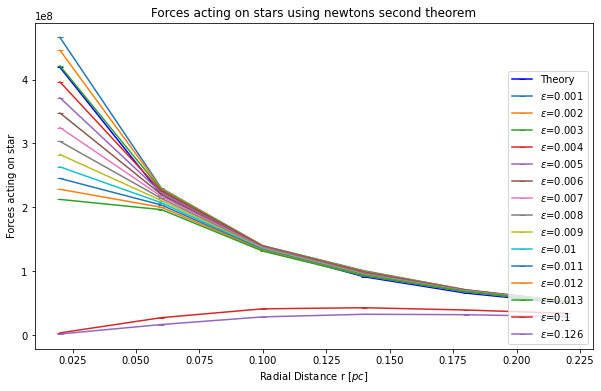

In [146]:
plt.figure(figsize=(10, 6))
plt.plot(distance_r_list, theor_mags_list, marker='_',label='Theory', color='blue')

#for i,distance_r in enumerate(distance_r_list):
for i,epsilon in enumerate(epsilons):
#    plt.plot(df_num_mags.loc[i].values, distance_r_list, marker='_',label=f'Numerical forces acting on star with $\epsilon$={epsilon}')
    plt.plot(distance_r_list, df_num_mags.loc[i].values, marker='_',label=f'$\epsilon$={epsilon}')
plt.legend(loc='lower right')
plt.xlabel('Radial Distance r $[pc]$')
plt.ylabel('Forces acting on star')
plt.title('Forces acting on stars using newtons second theorem', fontsize = 12)
plt.show()

So scaling and shape is similar so i think I am on right track. THe profile is decreasing as expected with $1/r^2$

So with this data right now a good epsilon is around 0.003

### Computation of relaxation timescale

Compute the relaxation timescale of the numerical model given the number of particles and the
physical crossing timescale (use the half-mass radius Rhm and the circular velocity computed
at the half-mass radius, 

$v_c =\sqrt{\frac{GM(R_{half})}{R_{half}}}$ 

Keeping in mind how the relaxation time
formula is derived, do you expect varying the value of the gravitational softening to change the
relaxation timescale? In particular, do you expect it to increase or decrease if the softening is
increased above the interparticle separation? Can you explain why?

Relaxation timescale is defined as

$t_{relax} = \frac{N_{stars}}{8 \ln{N_{stars}}}t_{cross}$

where $N_{stars} is the number of stars conatined in the cluster

$t_{cross}$ is the typical timescale rquired by particle to travel through the system on a straight trajectory and defined as

$t_{cross} = \frac{R_{half}}{V_{c}}$

Is it thought $R_{half}$ in the numerator for the t_cross?

In [192]:
def t_relax_f(N_stars,t_cross):
    t_relax =(N_stars)/(8*np.log(N_stars))*(t_cross)
    return t_relax

def t_cross_f(r_half,m_half):
    v_c = np.sqrt((m_half)/(r_half))
    t_cross = r_half/v_c
    return t_cross

Calculating relaxation timescale

In [196]:
m_half = df_stars[df_stars['distance'] <= r_half].shape[0]*df_stars["mass"].values[0]# stars within half_mass times mass
N_stars = df_stars.shape[0] #number of stars
t_cross = t_cross_f(r_half,m_half)
t_relax = t_cross_f(N_stars,t_cross)
print(f'The numerical model relaxation timescale: {t_relax}')

The numerical model relaxation timescale: 1522798553.3435316


The units must be set in order to use these and the a-fit has to be calculated to get the best answer I think

Do I have to do this with the b_max and b_min also? or the previous formula will suffice?

## Tree code 

Compute the force on particles (a subset of them would be fine) using multipole expansion
(tree-code). For multipole calculation decide on a criterion (distance based) to group particles,
eventually experimenting with different orders of the expansion. Finally, compare the tree-code
result with the direct summation result, in terms of accuracy as well as computational cost. Try
different softenings for the direct summation and different opening angles for the tree-code.

To test and use the treecode I will first use some small toy subsamle. Say 213 stars at radius 0.0055 pc

For the treecode I will probably use the octree implementation. From chat gpt:

### Step 1: Understand the Problem
You have a dataset describing a star cluster with columns for mass and 3D coordinates (x, y, z) of each star.

### Step 2: Define Particle and TreeNode Classes
Create a Particle class to represent stars with attributes like mass, position, and force.

Create a TreeNode class to represent nodes in the octree, storing information such as center, size, total mass, center of mass, and children.

### Step 3: Build the Octree
Define a function to build the octree (build_tree).

The function should take stars, a center, and a size as parameters.

Initialize the root node with the provided center and size.

Iterate over each star in the dataset and insert it into the octree.

To insert a star, navigate through the tree recursively, creating child nodes as needed.

### Step 4: Inserting Stars into the Octree
When inserting a star into a node, check if the star is within the boundaries of the node.

If the node is a leaf (no children), update the total mass and center of mass of the node.

If the node has children, determine the appropriate child node based on the star's position and insert the star there.

### Step 5: Compute Forces Using the Octree
Define a function to compute forces (compute_force).

Given a particle (star) and a node, calculate the distance vector between the particle and the center of mass of the node.

Use the Barnes-Hut criterion to decide whether to use the center of mass approximation or recurse into the node's children.

If approximating, calculate the gravitational force and update the particle's force attribute.

### Step 6: Main Function
Create a main function to orchestrate the entire process.

Load your star data into a list of Particle objects.

Build the octree using the build_tree function.

Iterate over each star and compute forces using the compute_force function.

Print or store the results.

### Step 7: Adjust Parameters

Tweak parameters such as the initial size of the space in the octree, the Barnes-Hut criterion threshold, and others based on your specific 
dataset and performance requirements.

### Step 8: Testing and Optimization

Test your implementation with different datasets to ensure correctness.

Optimize the code based on profiling and performance considerations.

By following these logical steps, you can implement an octree-based algorithm for calculating forces in your star cluster dataset efficiently.






In [5]:
radius = 0.0055
df_stars_sub = df_stars[df_stars['distance'] <= radius]
df_stars_sub.describe()

mass           x           y           z           vx  \
count  2.130000e+02  213.000000  213.000000  213.000000   213.000000   
mean   9.242590e+01   -0.000051    0.000206   -0.000076    61.159464   
std    1.424433e-13    0.002324    0.002162    0.002238  1831.637281   
min    9.242590e+01   -0.005187   -0.005311   -0.005240 -5416.710000   
25%    9.242590e+01   -0.001681   -0.001115   -0.001673 -1193.810000   
50%    9.242590e+01    0.000153    0.000106    0.000080   -69.378600   
75%    9.242590e+01    0.001658    0.001654    0.001547  1430.150000   
max    9.242590e+01    0.005113    0.005348    0.005233  4072.370000   

                vy           vz          soft           pot    distance  \
count   213.000000   213.000000  2.130000e+02  2.130000e+02  213.000000   
mean    213.385406   283.408768  1.000000e-01  1.302150e-02    0.003653   
std    1942.990686  1819.789853  1.530153e-16  4.520906e-17    0.001313   
min   -5027.560000 -5224.400000  1.000000e-01  1.302150e-02    0.000366   
25%    -976.545000  -845.131000  1.000000e-01  1.302150e-02    0.002592   
50%     320.394000   227.349000  1.000000e-01  1.302150e-02    0.003771   
75%    1434.330000  1328.080000  1.000000e-01  1.302150e-02    0.004762   
max    5589.500000  6290.370000  1.000000e-01  1.302150e-02    0.005470   

             v_mag  
count   213.000000  
mean   2959.685031  
std    1330.749295  
min     422.221331  
25%    1953.836378  
50%    2741.462767  
75%    3927.460395  
max    6611.607094

I will use some easier setup at first

In [226]:

examp_stars = [
      [-0.45,-0.45,-0.45],#(000): Bottom-left-front octant i = 0
      [+0.45,-0.45,-0.45],#(001): Bottom-right-front octant i = 1
      [-0.45,+0.45,-0.45],#(010): Top-left-front octant i = 2
      [+0.45,+0.45,-0.45],#(011): Top-right-front octant i = 3
      [-0.45,-0.45,+0.45],#(100): Bottom-left-back octant i = 4
      [+0.45,-0.45,+0.45],#(101): Bottom-right-back octant i = 5
      [-0.45,+0.45,+0.45],#(110): Top-left-back octant i = 6
      [0.45,0.45,0.45],#(111): Top-right-back octant i = 7
      [0.245,0.245,0.245], # extra in Top-right-back octant i = 7
      [0.11,0.11,0.11]
]
column_names = ["x","y","z"]
df_examp_stars = pd.DataFrame(examp_stars, columns=column_names)

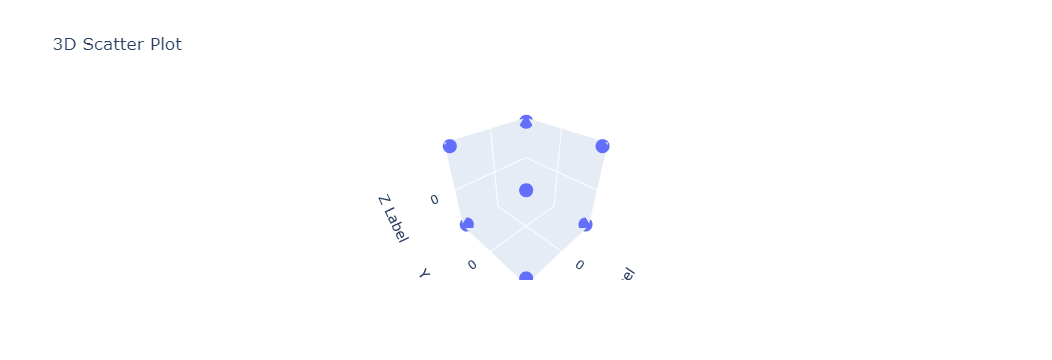

In [227]:
# Assuming df is your DataFrame
# Replace 'x', 'y', 'z' with your actual column names
fig = px.scatter_3d(df_examp_stars, x='x', y='y', z='z', title='3D Scatter Plot', size_max = 2)

# You can customize the labels for each axis
fig.update_layout(scene=dict(xaxis_title='X Label', yaxis_title='Y Label', zaxis_title='Z Label'))

# Show the interactive plot
fig.show()

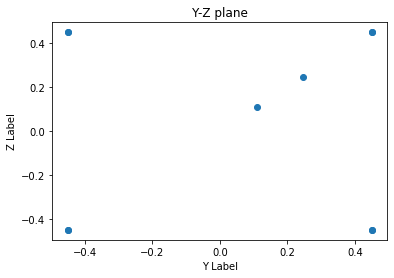

In [229]:
fig = plt.figure()
ax = fig.add_subplot(111,)

ax.scatter(df_examp_stars['y'], df_examp_stars['z'])

ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')


plt.title("Y-Z plane")
plt.show()

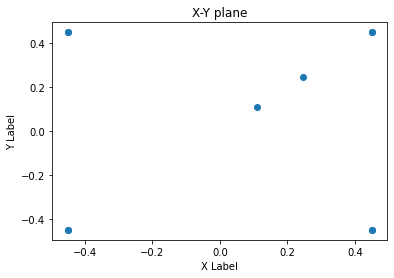

In [230]:
fig = plt.figure()
ax = fig.add_subplot(111,)

ax.scatter(df_examp_stars['x'], df_examp_stars['y'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

plt.title("X-Y plane")
plt.show()

In [103]:
help(calculate_total_force)

Help on function calculate_total_force in module __main__:

calculate_total_force(stars, epsilon)
    # Function to calculate total force on each star



First let's do a force calculation with the stars with the direct force calculation

In [117]:
reset_df_stars_sub = df_stars_sub.reset_index(drop=True)

In [241]:
# Record start time
start_time = time.time()
forces = calculate_total_force(reset_df_stars_sub, epsilon = 0.003)
# Record end time
end_time = time.time()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time

In [175]:
#forces

In [188]:
#Define a class for particles that describes its mass,position and force

class starObj:
    def __init__(self, position, org_index = None):
        self.mass = 92.4259 #every star has same mass anyway
        self.position = np.array(position)
        self.force = np.zeros(3)
        self.org_index = org_index

#Define a octree treenode
class TreeNode:
    def __init__(self, center, size):
        self.center = np.array(center)
        self.size = size
        self.total_mass = 0
        self.center_of_mass = np.zeros(3)
        self.children = [None] * 8 #octree structure

In [179]:
# build the tree
def build_tree(stars, center, size):
    root = TreeNode(center, size)
    for star in stars:
        #print("inserting star")
        print(root.children)
        insert_star(root, star)
    return root

 In Python, the all() function is used to determine if all elements of an iterable are true. It takes an iterable (like a list, tuple, or any other iterable) as an argument and returns True if all elements in the iterable are true, otherwise, it returns False.

In [234]:
def insert_star(node,star):
    #first lets check if the star is inside the current node's region
    if(
        abs(star.position[0] - node.center[0]) < 0.5 * node.size and
        abs(star.position[1] - node.center[1]) < 0.5 * node.size and
        abs(star.position[2] - node.center[2]) < 0.5 * node.size
    ):
        if all(child is None for child in node.children):#check if all the children nodes are None in a node # 
            #if this condition true this is a leaf node so only star (no children)
            print("no children")
            node.total_mass += star.mass
            node.center_of_mass += star.mass *star.position
        #but if it is not the only star (so there are children) insert the star inside the first nodes children
        else:
            i = 0
            #finding the corresponding octant from 
            for dim in range(3):
                if star.position[dim] > node.center[dim]:
                    i |= (1 << dim) #some trick I found to ("Use bitwise OR to set the corresponding bit")
            #print(i)
            
            if node.children[i] is None:
                # Create child node if it doesn't exist = None
                child_center = [
                    node.center[0] + 0.25 * node.size * (1 if i & 1 else -1),
                    node.center[1] + 0.25 * node.size * (1 if i & 2 else -1),
                    node.center[2] + 0.25 * node.size * (1 if i & 4 else -1),
                ]
                #insert the child node
                print("inserting child")
                node.children[i] = TreeNode(child_center, 0.5 * node.size)
            # Recursively insert the star into the appropriate child node
            insert_star(node.children[i], star)

In [237]:
def compute_force(particle, node):
    G = 1  # gravitational constant

    # Calculate distance vector between the particle and the center of mass of the node
    r = node.center_of_mass - particle.position
    distance = np.linalg.norm(r)

    # Use the Barnes-Hut criterion to check if the node can be approximated
    theta = 0.5 # Adjust this threshold as needed
    if node.size / distance < theta:
        print(node.size / distance)
        # Node is sufficiently far, use center of mass to calculate force
        force_magnitude = G * particle.mass * node.total_mass / distance**3
        particle.force += force_magnitude * r
    else:
        print("else")
        # Recursively compute forces for the node's children
        for child in node.children:
            if child is not None:
                print("recursive")
                compute_force(particle, child)

In [231]:
stars = []
for index,row in df_examp_stars[["x","y","z"]].iterrows(): #take the original index and coordinates of a star
    #print(index)
    #print(row.values)
    star = starObj(position = row.values, org_index = index)
    stars.append(star)

In [238]:
root = build_tree(stars, center=(0, 0, 0), size=1)  # Adjust size based on your data

[None, None, None, None, None, None, None, None]
no children
[None, None, None, None, None, None, None, None]
no children
[None, None, None, None, None, None, None, None]
no children
[None, None, None, None, None, None, None, None]
no children
[None, None, None, None, None, None, None, None]
no children
[None, None, None, None, None, None, None, None]
no children
[None, None, None, None, None, None, None, None]
no children
[None, None, None, None, None, None, None, None]
no children
[None, None, None, None, None, None, None, None]
no children
[None, None, None, None, None, None, None, None]
no children


In [239]:
#for size look into the the  stars dataframe.describe() and take the max abs value for coordinates and add a bit length and
#multiply by 2
size=0.0054*2
# Set up the root node of the octree
root = build_tree(stars, center=(0, 0, 0), size=size)  # Adjust size based on your data
for star in stars:
    compute_force(star, root)

[None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None]
0.013856406460551019
0.013856406460551019
0.013856406460551019
0.013856406460551019
0.013856406460551019
0.013856406460551019
0.013856406460551019
0.013856406460551019
0.0254505424785631
0.05668529915679962


In [161]:
for star in stars:
    print(f"Star Force: {star.force}")

Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force: [0. 0. 0.]
Star Force:

In [79]:
root.total_mass

19686.716699999968

In [40]:
#My brain is melting here this might not be correct.

#a node is separeted into octants
#bottom-left-front = (-x,-y-z) = blf
#blb = botto-left-back
blf = [-0.5,-0.5,-0.5]#(000): Bottom-left-front octant i = 0
brf = [+0.5,-0.5,-0.5]#(001): Bottom-right-front octant i = 1
tlf = [-0.5,+0.5,-0.5]#(010): Top-left-front octant i = 2
trf = [+0.5,+0.5,-0.5]#(011): Top-right-front octant i = 3
blb = [-0.5,-0.5,+0.5]#(100): Bottom-left-back octant i = 4
brb = [+0.5,-0.5,+0.5]#(101): Bottom-right-back octant i = 5
tlb = [-0.5,+0.5,+0.5]#(110): Top-left-back octant i = 6
trb = [0.5,0.5,0.5]#(111): Top-right-back octant i = 7
node_center = [0,0,0]
i = 0

#finding the corresponding octant from 
for dim in range(3):
    if trb[dim] > node_center[dim]:
        i |= (1 << dim) #some trick I found to ("Use bitwise OR to set the corresponding bit")
print(i)

7


In [ ]:
if node.children[i] is None:
    # Create child node if it doesn't exist
    child_center = [
        node.center[0] + 0.25 * node.size * (1 if i & 1 else -1),
        node.center[1] + 0.25 * node.size * (1 if i & 2 else -1),
        node.center[2] + 0.25 * node.size * (1 if i & 4 else -1),
    ]

### Time integration

Using an appropriate time integrator among those that you have studied and tested earlier,
integrate the equation of motions using direct summation for a few systems’ crossing timescales
(see definition at Task 1 Step 2). Repeat the integration with different force softenings and
attempt to measure the magnitude of numerical relaxation in runs with

Probably something like a leapfrog should be used since it is simplectic

....

## From there extra stuff not in project

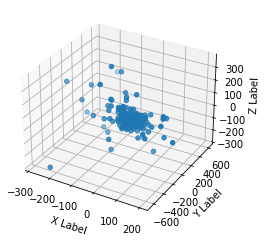

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_stars['x'], df_stars['y'], df_stars['z'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

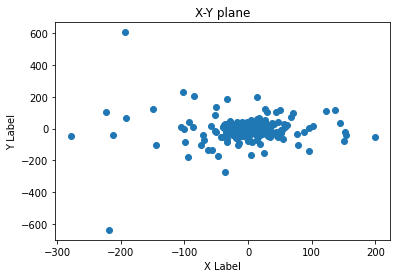

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111,)

ax.scatter(df_stars['x'], df_stars['y'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

plt.title("X-Y plane")
plt.show()

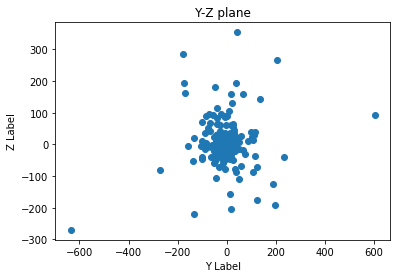

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111,)

ax.scatter(df_stars['y'], df_stars['z'])

ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')


plt.title("Y-Z plane")
plt.show()

So I have to first do a histogram of of masses. 
What would the binning be?
Should do a programm that creates bins with changable lentgh and fills them.

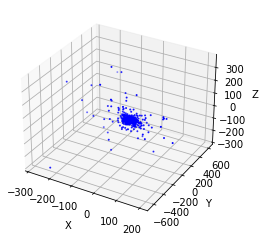

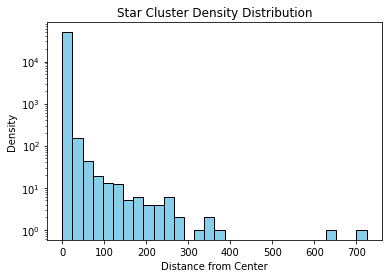

In [68]:
# Assuming 'star_df' is your DataFrame with columns 'x', 'y', 'z'
# Calculate the distance of each star from the center (middle) of the cluster
star_df = df_stars

#star_df['distance'] = np.sqrt(star_df['x']**2 + star_df['y']**2 + star_df['z']**2)

# Plot the 3D distribution of stars (optional but useful for visualization)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(star_df['x'], star_df['y'], star_df['z'], s=1, c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Create a histogram of the distances
plt.hist(star_df['distance'], bins=30, color='skyblue', edgecolor='black',log = True)
#plt.xlim(0, 4) 
plt.title('Star Cluster Density Distribution')
plt.xlabel('Distance from Center')
plt.ylabel('Density')
plt.show()

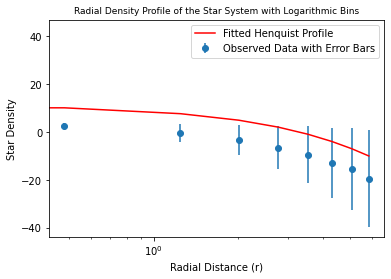

In [67]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes # This is the lambda

# Calculate Poisson errors
errors = np.sqrt(hist) / shell_volumes # This is the np.sqrt(lambda)

# Use curve_fit to find the optimal parameters with errors
params, covariance = curve_fit(hernquist_profile, bin_edges[:-1], star_density, sigma=errors, absolute_sigma=True)



# Plot the observed data and the fitted profile with error bars
plt.errorbar(np.log(bin_edges[:-1]), np.log(star_density), yerr=np.log(errors), fmt='o', label='Observed Data with Error Bars')
plt.plot(np.log(bin_edges[:-1]), np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

In [ ]:
a_fit

array([1.29013535e+04, 5.33686134e-02])

In [28]:
print(len(params))

array([[3.33099418e+03, 4.76897331e-06],
       [4.76897332e-06, 1.15921231e-07]])

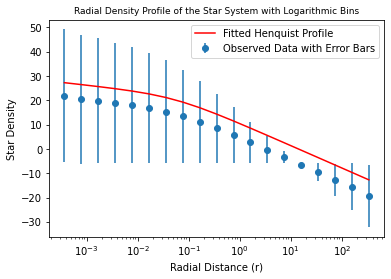

In [52]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin and get the bin edges
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell using the bin edges 
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes

# Use curve_fit to find the optimal parameter for a (scale factor)
params, covariance = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density, sigma=errors, absolute_sigma=True)

#extract the fitted scale factor a
a_fit = params

fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)

e_pos = fitted_profile-star_density/np.sqrt(hist)
# Plot the observed data and the fitted profile with error bars
plt.errorbar(bin_edges[:-1], np.log(star_density), yerr=np.log(e_pos), fmt='o', label='Observed Data with Error Bars')
#plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.plot(bin_edges[:-1], np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
#plt.axvline(x=np.log(a_fit), color='red', linestyle='--', label='scale radius a')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

In [53]:
pcov

array([[inf]])

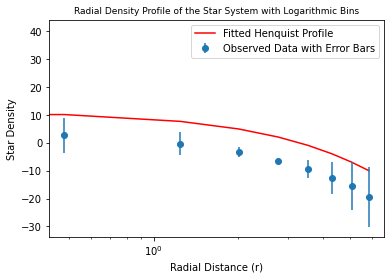

In [54]:
a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density)
fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)

#calculate error
e_pos = abs(fitted_profile-star_density)/np.sqrt(hist)


plt.plot(np.log(bin_edges[:-1]), np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
plt.errorbar(np.log(bin_edges[:-1]), np.log(star_density), yerr=np.log(e_pos), fmt='o', label='Observed Data with Error Bars')
#plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

In [31]:
a_fit

array([0.82558247])

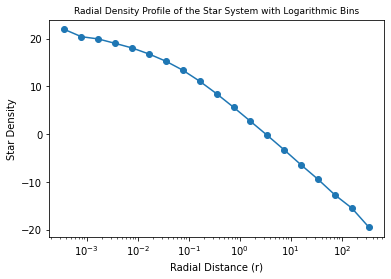

In [149]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes #rho_numerical

# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

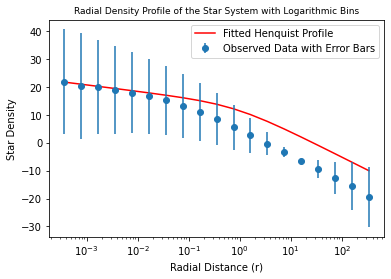

In [8]:
a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density)
fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)

#calculate error
e_pos = abs(fitted_profile-star_density)/np.sqrt(hist)


plt.plot(bin_edges[:-1], np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
plt.errorbar(bin_edges[:-1], np.log(star_density), yerr=np.log(e_pos), fmt='o', label='Observed Data with Error Bars')
#plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

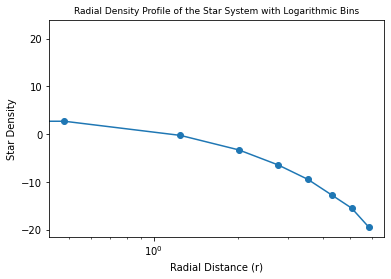

In [66]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3) #

# Calculate star density in each shell for 
star_density = hist / shell_volumes #rho_numerical

# Plot the radial density profile with logarithmic bins
plt.plot(np.log(bin_edges[:-1]), np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

fixed mass profile a value:[0.005]


/scratch/tmp.42882350.atepper/ipykernel_11146/4042980114.py:9: RuntimeWarning:

divide by zero encountered in divide

/scratch/tmp.42882350.atepper/ipykernel_11146/1931522589.py:31: RuntimeWarning:

divide by zero encountered in log

/scratch/tmp.42882350.atepper/ipykernel_11146/1931522589.py:33: RuntimeWarning:

divide by zero encountered in log



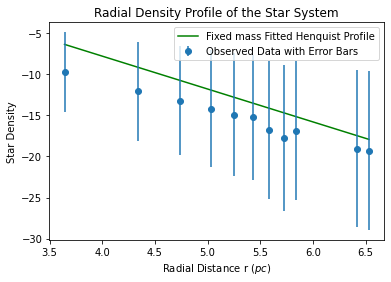

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# define radial distances
radial_distances = df_stars["distance"]

# Define radial bins
bins = np.linspace(0, np.max(radial_distances), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes


a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density,p0=0.005)
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)
print(f'fixed mass profile a value:{a_fit}')






# Plot the radial density profile
#plt.plot(np.log(bin_edges[:-1]), np.log(regular_fitted_profile), label='Fitted Henquist Profile', color='red')
plt.plot(np.log(bin_edges[:-1]), np.log(fixed_M_fitted_profile), label='Fixed mass Fitted Henquist Profile', color='green')
#plt.scatter(np.log(bins[:-1]), np.log(star_density), marker='o')
plt.errorbar(np.log(bin_edges[:-1]), np.log(star_density), yerr=np.log(sigma), fmt='o', label='Observed Data with Error Bars')
plt.xlabel('Radial Distance r ($pc$)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Radial Density Profile of the Star System')
plt.show()

In [ ]:
result_df = df[df['your_column'] == desired_value]


In [177]:
example_star = df_stars[df_stars["distance"] == 724.689657812915  ] 

In [178]:
example_star

mass        x        y        z       vx       vy       vz  soft  \
33830  92.4259 -219.267 -635.776 -269.974  61.1198 -28.4596  32.0028   0.1   

            pot    distance  
33830  0.013022  724.689658

In [179]:
r_tot = 724.689657812915#pc
v = np.sqrt(total_mass/724.689657812915)

In [180]:
v

79.86366559905319

In [ ]:
# Example DataFrame with columns: 'StarID', 'X', 'Y', 'Z'
data = {'StarID': [1, 2, 3],
        'X': [1.0, 2.0, 3.0],
        'Y': [1.0, 1.5, 2.0],
        'Z': [5.0, 4.0, 2.0]}

star_cluster_df = pd.DataFrame(data)

# Calculate the Euclidean distance for each pair of particles (numpy)
distances_np = np.linalg.norm(star_cluster_df[['X', 'Y', 'Z']].values, axis=1)
print(distances_np)
# Calculate pairwise distances using Euclidean distance metric (scipy)
pairwise_distances = pdist(star_cluster_df[['X', 'Y', 'Z']].values, metric='euclidean')
print(pairwise_distances)
# Convert to a square matrix
distance_matrix = squareform(pairwise_distances)

# Exclude diagonal elements (distances to themselves)
non_diagonal_distances = distance_matrix[~np.eye(distance_matrix.shape[0], dtype=bool)]

# Calculate the mean distance for both approaches
mean_distance_np = distances_np[distances_np != 0].mean()
mean_distance_scipy = non_diagonal_distances.mean()

print(f"Mean Distance between particles (numpy): {mean_distance_np}")
print(f"Mean Distance between particles (scipy): {mean_distance_scipy}")

In [ ]:
#Parallelized version. Not sure if works, because 1000 particle really did not show any speed up against the regular on
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def pairwise_distance(args):
    i, j, star_coordinates = args
    return euclidean_distance(star_coordinates.iloc[i], star_coordinates.iloc[j])

def mean_distance(star_coordinates):
    num_stars = len(star_coordinates)
    total_distance = 0.0

    # Using ThreadPoolExecutor for parallelization
    with ThreadPoolExecutor() as executor:
        # Create a list of argument tuples for pairwise_distance function
        args_list = [(i, j, star_coordinates) for i in range(num_stars) for j in range(i+1, num_stars)]
        
        # Map the pairwise_distance function to the list of arguments using multiple threads
        distances = list(executor.map(pairwise_distance, args_list))

        # Sum up the distances
        total_distance = sum(distances)

    # Calculate the mean distance
    mean_distance = total_distance / (num_stars * (num_stars - 1) / 2)
    return mean_distance

# Example coordinates of 10 stars in a DataFrame
# the half mass radius stars coordinates
star_cluster_df = f_df_stars[["x","y","z"]][:1000]

result = mean_distance(star_cluster_df)
print(f"Mean distance between stars: {result}")

In [35]:
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force

In [38]:
stars = df_stars[:2]
i=0
j=1
calculate_force(stars['mass'][j],
                stars['x'][i], stars['y'][i], stars['z'][i],
                stars['x'][j], stars['y'][j], stars['z'][j], epsilon)

array([ -270.48838683, -1612.50867626,    77.70457927])

In [37]:
stars = df_stars[:2]
stars["mass"]

0    92.4259
1    92.4259
Name: mass, dtype: float64

In [ ]:

#plt.plot(distance_r_list, theor_mags_list, marker='_',label='Theoretical forces acting on a star', color='blue')
#for i,distance_r in enumerate(distance_r_list):
for i,epsilon in enumerate(epsilons):
#    plt.plot(df_num_mags.loc[i].values, distance_r_list, marker='_',label=f'Numerical forces acting on star with $\epsilon$={epsilon}')
    plt.plot(distance_r_list, df_num_mags.loc[i].values, marker='_',label=f'Numerical forces acting on star with $\epsilon$={epsilon}')
plt.legend()
plt.xlabel('Radial Distance r $[pc]$')
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]')
plt.title('Radial Density Profile of the Star System with guessed profile', fontsize = 9)
plt.show()

Old version of direct force calculation beofre changing for loops

In [109]:
# Function to calculate gravitational force with softening
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force
# Function to calculate total force on each star
def calculate_total_force(stars, epsilon):
    forces = np.zeros((len(stars), 3))

    for i in range(len(stars)):
        #print(i)
        for j in range(len(stars)):
            if i != j:
                force = calculate_force(stars['mass'][j],
                                        stars['x'][i], stars['y'][i], stars['z'][i],
                                        stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
                forces[i] += force

    return forces

In [ ]:
#Seems to work better.
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force


def calculate_force_parallel_proc(i):
    if i % 1000 == 0:
        print(i)
    
    forces = np.zeros(3)
    for j in range(len(stars)):
        if i != j:
            
            forces += calculate_force( stars['mass'][j],
                                       stars['x'][i], stars['y'][i], stars['z'][i],
                                       stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
        else: 
            forces += np.zeros(3)
        
    return forces 
def calculate_total_force_parallel_proc(stars, epsilon, num_workers=30):
    with ProcessPoolExecutor(max_workers = num_workers) as executor:
        nr_stars = range(len(stars))
        results = executor.map(calculate_force_parallel_proc, nr_stars)
    
    
    forces = np.array(list(results))
    
    return forces